# Task 2 Encoding and Classifier

In [1]:
!pip install pennylane

     |████████████████████████████████| 800 kB 5.4 MB/s 
     |████████████████████████████████| 1.6 MB 48.0 MB/s 
     |████████████████████████████████| 7.8 MB 19.4 MB/s 
     |████████████████████████████████| 108 kB 52.8 MB/s 


In [17]:
import numpy as np     # Loading the libraries for the implementation
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import pennylane as qml   # Using Pennylane libraries for Quantum Computations part
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

In [10]:
train_data = pd.read_csv("mock_train_set.csv") #viewing the training set
train_data

,0,1,2,3,4
0,2789.26,1000.0,10.0,20.0,0.0
1,4040.01,1000000.0,1.0,1.0,1.0
2,2931.20,10000.0,10000.0,40.0,1.0
3,3896.54,10000.0,100000.0,30.0,1.0
4,982.06,100.0,1000.0,75.0,0.0
...,...,...,...,...,...
295,1464.52,1000000.0,10000.0,45.0,1.0
296,3493.66,1000000.0,100000.0,85.0,1.0
297,4182.81,1.0,1.0,65.0,0.0
298,3113.75,10000.0,100.0,1.0,1.0


In [11]:
test_data = pd.read_csv("mock_test_set.csv") #viwing the test data
test_data

,0,1,2,3,4
0,2988.55,10000.0,10000.0,75.0,1.0
1,3413.80,1.0,100.0,90.0,0.0
2,3891.52,1.0,1.0,5.0,0.0
3,4514.99,10000.0,1000000.0,25.0,1.0
4,752.29,10.0,10.0,90.0,0.0
...,...,...,...,...,...
115,3155.94,10000.0,10000.0,35.0,1.0
116,2795.04,1.0,10.0,45.0,0.0
117,3702.48,1.0,1.0,20.0,0.0
118,2790.57,1.0,1.0,40.0,0.0


In [12]:
train_data = np.array(train_data) #fine tunning the data for encoding
x_train = train_data[:,0:4]    # using columns from 0 to 3 for training
scalerx = StandardScaler().fit(x_train)
x_train = scalerx.transform(x_train)
y_train = train_data[:,4]
y_train = 2*(y_train - 0.5)

test_data = np.array(test_data)
x_test = test_data[:,0:4]
scalerX = StandardScaler().fit(x_test)
x_test = scalerX.transform(x_test)
y_test = test_data[:,4]
y_test = 2*(y_test - 0.5)

In [14]:
n_qubits = len(x_train[0]) # == number of features we want to use for the training (for angle encoding)
n_qubits

4

In [34]:
# using Quantum Kernel Method

In [15]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)

def kernel(x1, x2):  #the quantum kernel
  AngleEmbedding(x1, wires=range(n_qubits))
  qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
  return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

def kernel_matrix(A, B): # computing the kernel matrix
  return np.array([[kernel(a, b) for b in B] for a in A])

In [18]:
svm = SVC(kernel=kernel_matrix).fit(x_train, y_train) # training the SVM

In [29]:
#arbitary predicting the 69th entry of x_test and comparing with its y_test
print("Predicted Value = ",svm.predict([x_test[69]])[0],"& Actual Value = ",y_test[69])

Predicted Value =  1.0 & Actual Value =  1.0


In [30]:
predictions = svm.predict(x_test) # Analysing the prediction for test dataset
accuracy_score(predictions, y_test)

0.8666666666666667

In [38]:
#using the Variational Method

In [41]:
dev_var = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")

def quantum_model(x, params): # variational circuit
  AngleEmbedding(x, wires=range(n_qubits))
  StronglyEntanglingLayers(params, wires=range(n_qubits))
  return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias): # adding bias to the system
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    hinge_loss = relu(hinge_loss)
    return hinge_loss

def quantum_model_train(n_layers, steps, batch_size): # training the variational circuit
   
    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(x_train), batch_size)

        X_batch = x_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack([quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch])
            loss = torch.mean(hinge_loss(preds, y_batch_torch))
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias): # predicting the result
    
    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

step 0 , loss 1.1505295585402282
step 10 , loss 0.965950705664849
step 20 , loss 0.9583043964768081
step 30 , loss 0.8382898613390118
step 40 , loss 0.9931068775615541
accuracy on test set: 0.575


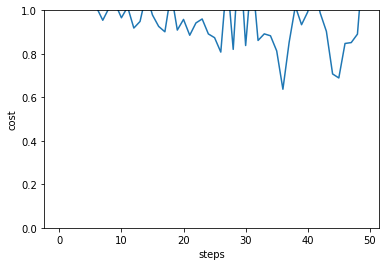

In [44]:
n_layers = 2
batch_size = 20
steps = 50
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(x_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()


step 0 , loss 1.0248552302099445
step 10 , loss 0.9069266767197413
step 20 , loss 0.8808269852579619
step 30 , loss 0.49176155224593376
step 40 , loss 0.5371279113960882
accuracy on test set: 0.8083333333333333


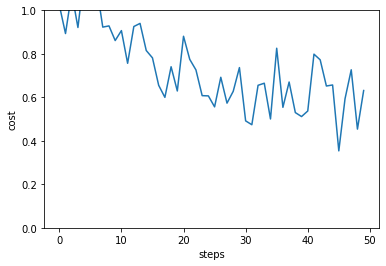

In [42]:
n_layers = 3
batch_size = 20
steps = 50
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(x_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()


step 0 , loss 0.9359088922051422
step 10 , loss 0.7232912524727761
step 20 , loss 0.7170092224092759
step 30 , loss 0.5852200674045819
step 40 , loss 0.7484420665638352
accuracy on test set: 0.7916666666666666


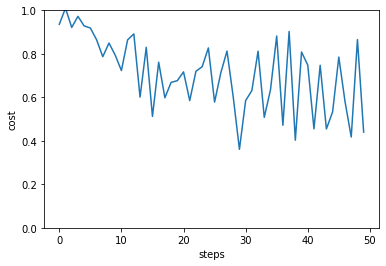

In [43]:
n_layers = 4
batch_size = 20
steps = 50
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(x_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()


step 0 , loss 1.0265856673095293
step 10 , loss 0.9710646775310504
step 20 , loss 0.883417367736617
step 30 , loss 0.8228375732216978
step 40 , loss 0.6321652818269461
accuracy on test set: 0.8666666666666667


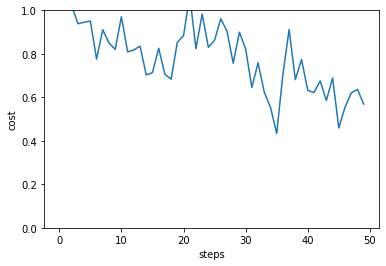

In [45]:
n_layers = 5
batch_size = 20
steps = 50
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(x_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

step 0 , loss 1.1211819130054963
step 10 , loss 0.8785504006111469
step 20 , loss 0.9764708472295304
step 30 , loss 0.5139181310037588
step 40 , loss 0.6898935384436697
accuracy on test set: 0.8666666666666667


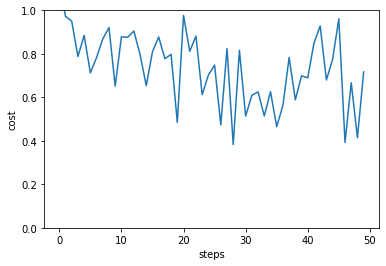

In [47]:
n_layers = 6
batch_size = 20
steps = 50
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(x_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [ ]:
# We see that accuracy on test datasets is optimum for five layers (n=5) in this case.

In [46]:
# Acknowledgement : Demos section, Pennylane